Normalize ZIPs - 0:00:00.010718
Load ZIP boundaries - 0:00:01.927044
Merge data → ZIP geometries - 0:00:00.015589
Track originally unassigned ZIPs - 0:00:00.000821
Auto-fill unassigned ZIPs (optional) - 0:00:00.032495
Build unassigned report (ALWAYS) - 0:00:00.002370
Filter to CONUS + AK + HI + PR - 0:00:00.015621
Transform ZIP geometries - 0:00:00.755796
Load & transform state boundaries - 0:00:00.098633
Clip - 0:00:14.054272
Leader lines - 0:00:00.003382
Plot (COLOR + HATCHING) - 0:01:08.950913
Custom legend - 0:00:00.002854
Overlays - 0:00:17.596560
Final styling - 0:00:00.010686
Total Execution time: 0:01:43.479600


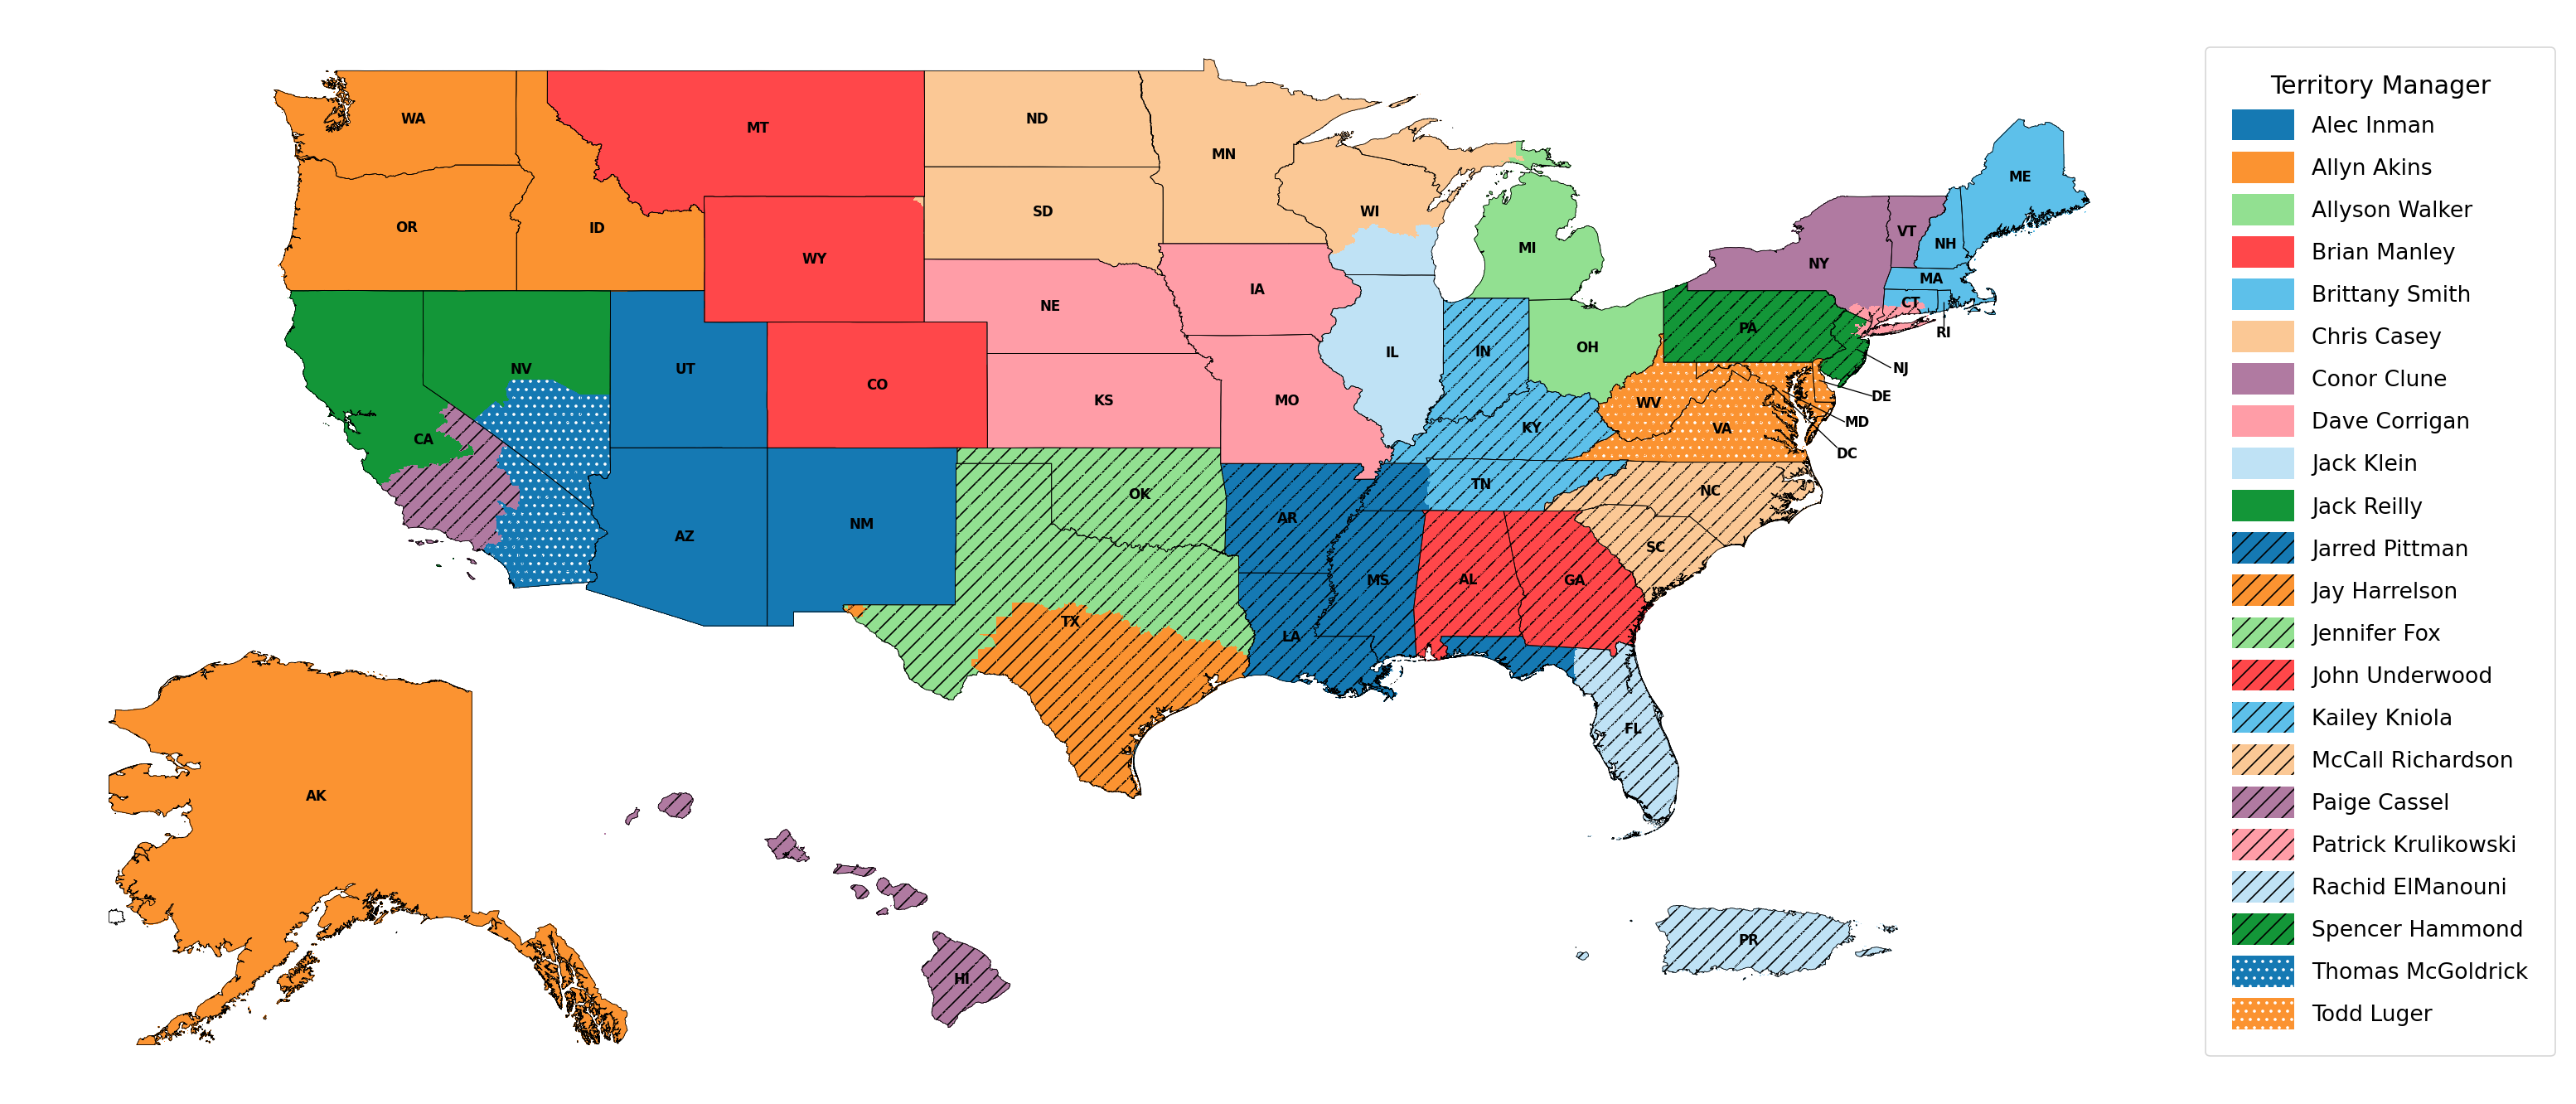

In [1]:
from io import BytesIO
import json
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import LineString
from shapely.affinity import scale, translate
from shapely.geometry import box


def find_state_loc(state_abbr: str, state_locs):
    for state_loc in state_locs:
        if state_loc["STATE_ABBR"] == state_abbr:
            return state_loc
    return None


def get_state_locs():
    with open("./state_abbv_offsets.json", "r") as f:
        return json.load(f)


def fig_to_png_bytes(fig):
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches="tight")
    buf.seek(0)
    return buf

data_df = pd.read_excel("./data/territory_map.xlsx")
zip_col = "Zip"
value_col = "Territory Manager"
map_colors = [
    "#1579b3",
    "#fb9331",
    "#92e091",
    "#ff474a",
    "#5dc0ea",
    "#fbc895",
    "#B07AA1",
    "#FF9DA7",
    "#bfe2f5",
    "#139638",
]
auto_fill_unassigned=True
map_title=None


# def generate_map(
#     data_df,
#     zip_col,
#     value_col,
#     map_colors,
#     auto_fill_unassigned=False,
#     map_title=None,
# ):

    

from matplotlib.patches import Patch
from datetime import datetime

def log_time(start_time, label):
    print(f"{label} - {datetime.now() - start_time}")

start_time = datetime.now()
state_locs = get_state_locs()

# -----------------------------
# Normalize ZIPs
# -----------------------------
event_time = datetime.now()
data_df = data_df.copy()
data_df[zip_col] = data_df[zip_col].astype(str).str.zfill(5)
log_time(event_time, "Normalize ZIPs")

# -----------------------------
# Load ZIP boundaries
# -----------------------------
event_time = datetime.now()
zip_gdf = gpd.read_file("./data/zip_code_boundaries.shp")
log_time(event_time, "Load ZIP boundaries")

# -----------------------------
# Merge data → ZIP geometries
# -----------------------------
event_time = datetime.now()
gdf = zip_gdf.merge(
    data_df,
    left_on="ZIP_CODE",
    right_on=zip_col,
    how="left",
)
log_time(event_time, "Merge data → ZIP geometries")

# -----------------------------
# Track originally unassigned ZIPs
# -----------------------------
event_time = datetime.now()
originally_unassigned_mask = gdf[value_col].isna()
log_time(event_time, "Track originally unassigned ZIPs")


# -----------------------------
# Auto-fill unassigned ZIPs (optional)
# -----------------------------
event_time = datetime.now()
if auto_fill_unassigned:
    gdf["ZIP_INT"] = gdf["ZIP_CODE"].astype(int)

    assigned_lookup = (
        gdf.dropna(subset=[value_col]).set_index("ZIP_INT")[value_col].to_dict()
    )

    def find_nearest_value(zip_int, lookup, max_radius=500):
        for d in range(1, max_radius + 1):
            if zip_int - d in lookup:
                return lookup[zip_int - d]
            if zip_int + d in lookup:
                return lookup[zip_int + d]
        return "unassigned"

    gdf.loc[originally_unassigned_mask, value_col] = gdf.loc[
        originally_unassigned_mask, "ZIP_INT"
    ].apply(lambda z: find_nearest_value(z, assigned_lookup))

    gdf.drop(columns="ZIP_INT", inplace=True)
log_time(event_time, "Auto-fill unassigned ZIPs (optional)")

# -----------------------------
# Build unassigned report (ALWAYS)
# -----------------------------
event_time = datetime.now()
unassigned_df = (
    gdf.loc[originally_unassigned_mask, ["ZIP_CODE", value_col]]
    .fillna({value_col: "unassigned"})
    .rename(columns={value_col: "assigned_value"})
    .reset_index(drop=True)
)
log_time(event_time, "Build unassigned report (ALWAYS)")


# -----------------------------
# Filter to CONUS + AK + HI + PR
# -----------------------------
event_time = datetime.now()
bounds = gdf.geometry.bounds
gdf = gdf[
    (
        (bounds.minx > -130)
        & (bounds.maxx < -60)
        & (bounds.miny > 24)
        & (bounds.maxy < 50)
    )
    | (
        (bounds.minx > -170)
        & (bounds.maxx < -130)
        & (bounds.miny > 50)
        & (bounds.maxy < 72)
    )
    | (
        (bounds.minx > -161)
        & (bounds.maxx < -154)
        & (bounds.miny > 18)
        & (bounds.maxy < 23)
    )
    | (
        (bounds.minx > -68)
        & (bounds.maxx < -65)
        & (bounds.miny > 17)
        & (bounds.maxy < 19.5)
    )
].copy()
log_time(event_time, "Filter to CONUS + AK + HI + PR")

# -----------------------------
# Transform ZIP geometries
# -----------------------------
event_time = datetime.now()
for i, row in gdf.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds

    if -170 < minx < -130 and 50 < miny < 72:  # Alaska
        geom = scale(row.geometry, 0.45, 0.75, origin=(0, 0))
        geom = translate(geom, -55, -23)
    elif -68 < minx < -65 and maxy < 30:  # Puerto Rico
        geom = scale(row.geometry, 3.75, 3.75, origin=(0, 0))
        geom = translate(geom, 171.5, -47)
    elif -172 < minx < -154 and miny < 50:  # Hawaii
        geom = scale(row.geometry, 2.25, 2.25, origin=(0, 0))
        geom = translate(geom, 247, -24)
    else:
        continue

    gdf.at[i, "geometry"] = geom
log_time(event_time, "Transform ZIP geometries")

# -----------------------------
# Load & transform state boundaries
# -----------------------------
event_time = datetime.now()
states = gpd.read_file("./data/state_boundaries.shp")
states = states[~states["STATE_ABBR"].isin(["VI", "GU", "MP", "AS"])]
states = states.to_crs(gdf.crs)

for i, row in states.iterrows():
    abbr = row["STATE_ABBR"]
    geom = row.geometry

    if abbr == "AK":
        geom = scale(geom, 0.45, 0.75, origin=(0, 0))
        geom = translate(geom, -55, -23)
    elif abbr == "HI":
        geom = scale(geom, 2.25, 2.25, origin=(0, 0))
        geom = translate(geom, 247, -24)
    elif abbr == "PR":
        geom = scale(geom, 3.75, 3.75, origin=(0, 0))
        geom = translate(geom, 171.5, -47)

    states.at[i, "geometry"] = geom
log_time(event_time, "Load & transform state boundaries")


# -----------------------------
# Clip
# -----------------------------
event_time = datetime.now()
clip_box = box(-130, 18, -60, 55)
gdf = gpd.clip(gdf, clip_box)
states = gpd.clip(states, clip_box)
log_time(event_time, "Clip")

# -----------------------------
# Leader lines
# -----------------------------
event_time = datetime.now()
leader_lines = []
SMALL_STATES = {
    "DC": {"x": -0.3, "y": 0.2},
    "DE": {"x": -0.3, "y": 0},
    "MD": {"x": -0.4, "y": 0},
    "NJ": {"x": -0.3, "y": 0},
    "RI": {"x": 0, "y": 0.2},
}

for _, row in states.iterrows():
    abbr = row["STATE_ABBR"]
    if abbr not in SMALL_STATES:
        continue

    loc = find_state_loc(abbr, state_locs)
    anchor = row.geometry.representative_point()
    offset = SMALL_STATES[abbr]

    leader_lines.append(
        {
            "STATE_ABBR": abbr,
            "geometry": LineString(
                [
                    (anchor.x, anchor.y),
                    (
                        loc["label_x"] + offset["x"],
                        loc["label_y"] + offset["y"],
                    ),
                ]
            ),
        }
    )

leader_lines_gdf = gpd.GeoDataFrame(leader_lines, crs=states.crs)
log_time(event_time, "Leader lines")

# -----------------------------
# Plot (COLOR + HATCHING)
# -----------------------------
event_time = datetime.now()
fig, ax = plt.subplots(figsize=(26, 31), dpi=120)

unique_vals = sorted(gdf[value_col].dropna().unique())
base_colors = map_colors
hatches = [
    "",
    "//",
    "..",
    "xx",
    "\\\\",
]

style_map = {}
for i, val in enumerate(unique_vals):
    color = base_colors[i % len(base_colors)]
    hatch = hatches[i // len(base_colors)]
    style_map[val] = (color, hatch)

# Draw ZIPs group-by-group
for val, (color, hatch) in style_map.items():
    if hatch == "..":
        edge_color = "white"
    else:
        edge_color = "none"

    gdf[gdf[value_col] == val].plot(
        ax=ax,
        facecolor=color,
        hatch=hatch,
        edgecolor=edge_color,
        linewidth=0,
        antialiased=False,
        rasterized=True,
    )
log_time(event_time, "Plot (COLOR + HATCHING)")

# -----------------------------
# Custom legend
# -----------------------------
event_time = datetime.now()
legend_handles = []

for val, (color, hatch) in style_map.items():
    if hatch == "..":
        edge_color = "white"
    else:
        edge_color = "black"

    legend_handles.append(
        Patch(
            facecolor=color,
            hatch=hatch,
            edgecolor=edge_color,
            linewidth=0,
            label=val,
        )
    )

ax.legend(
    handles=legend_handles,
    loc="center right",
    title=value_col,
    title_fontsize=18,
    fontsize=16,
    frameon=True,
    handlelength=2.8,  # width of color box
    handleheight=1.8,  # height of color box
    labelspacing=0.5,  # vertical spacing between entries
    borderpad=1.2,  # padding inside legend box
)
log_time(event_time, "Custom legend")

# -----------------------------
# Overlays
# -----------------------------
event_time = datetime.now()
states.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", zorder=5)
leader_lines_gdf.plot(ax=ax, color="black", linewidth=0.8, zorder=6)

states["label_x"] = states["STATE_ABBR"].apply(
    lambda s: find_state_loc(s, state_locs)["label_x"]
)
states["label_y"] = states["STATE_ABBR"].apply(
    lambda s: find_state_loc(s, state_locs)["label_y"]
)

for _, row in states.iterrows():
    ax.text(
        row.label_x,
        row.label_y,
        row["STATE_ABBR"],
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="center",
        zorder=6,
    )
log_time(event_time, "Overlays")

# -----------------------------
# Final styling
# -----------------------------
event_time = datetime.now()
ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(map_title, fontsize=20, pad=20)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, xmax + 12)
plt.tight_layout()
log_time(event_time, "Final styling")

print(f"Total Execution time: {datetime.now()-start_time}")

# return fig, unassigned_df
